# (0) Driveのマウント と Signate API

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=692e90a3b8dbc9b16fbecebb7360e7726eacfe8bdb8a93e0d202ba89d62ed190
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [5]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


# (1) 外部ライブラリのインストール

In [6]:
!pip install kanjize

In [7]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.6 MB/s eta 0:00:00


In [8]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 12.9 MB/s eta 0:00:00


# (2) 前処理

In [13]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [14]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1")

# Ageの処理
for i in range(len(all_df)):
# for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10代は19歳にする
    if(-1<tmp & tmp<20):
      all_df.loc[i,"Age"] = 19
    elif(tmp>60):
      all_df.loc[i,"Age"] = 61
    else:
      # 10歳で分けて5足す
      tmp = tmp//10 * 10
      all_df.loc[i,"Age"] = tmp + 5

# int型に変換
all_df["Age"] = all_df["Age"].astype(int)

print(all_df.groupby("Age").size())

Age
-1     193
 18     17
 19     28
 20     47
 21     58
 22     81
 23     74
 24     96
 25    193
 26    123
 27    122
 28    160
 29    158
 30    194
 31    217
 32    234
 33    263
 34    234
 35    469
 36    257
 37    238
 38    206
 39    204
 40    188
 41    186
 42    198
 43    170
 44    129
 45    354
 46    146
 47    144
 48    125
 49    136
 50    165
 51    156
 52    154
 53    131
 54    131
 55    252
 56     97
 57     86
 58     63
 59     53
 60     30
 61     14
 65      4
dtype: int64


In [15]:
# カテゴリ列の追加
all_df["Age_cls"] = all_df["Age"].copy()

all_df.loc[all_df["Age"]<0,"Age_cls"] = "不明"
all_df.loc[(all_df["Age"]>=10) & (all_df["Age"]<=20),"Age_cls"] = "20歳以下"
all_df.loc[(all_df["Age"]>=21) & (all_df["Age"]<=25),"Age_cls"] = "21〜25歳"
all_df.loc[(all_df["Age"]>=26) & (all_df["Age"]<=30),"Age_cls"] = "26〜30歳"
all_df.loc[(all_df["Age"]>=31) & (all_df["Age"]<=35),"Age_cls"] = "31〜35歳"
all_df.loc[(all_df["Age"]>=36) & (all_df["Age"]<=40),"Age_cls"] = "36〜40歳"
all_df.loc[(all_df["Age"]>=41) & (all_df["Age"]<=45),"Age_cls"] = "41〜45歳"
all_df.loc[(all_df["Age"]>=46) & (all_df["Age"]<=50),"Age_cls"] = "46〜50歳"
all_df.loc[(all_df["Age"]>=51) & (all_df["Age"]<=55),"Age_cls"] = "51〜55歳"
all_df.loc[all_df["Age"]>=56,"Age_cls"] = "56歳以上"

# 元のカラムを削除する
all_df = all_df.drop("Age",axis=1)

all_df['Age_cls'] = all_df['Age_cls'].astype('object')
print(all_df.groupby(["Age_cls"]).size())

Age_cls
20歳以下       92
21〜25歳     502
26〜30歳     757
31〜35歳    1417
36〜40歳    1093
41〜45歳    1037
46〜50歳     716
51〜55歳     824
56歳以上      347
不明         193
dtype: int64


<ipython-input-15-6e1667c3d861>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["Age"]<0,"Age_cls"] = "不明"


In [16]:
#########################
# "TypeofContact"の処理 #
#########################
print(all_df.groupby("TypeofContact").size())

TypeofContact
Company Invited    2516
Self Enquiry       4444
dtype: int64


In [17]:
#########################
# "CityTier"の処理 #
#########################
all_df["CityTier"] = all_df["CityTier"].astype("object")
print(all_df.groupby("CityTier").size())

CityTier
1    2991
2    3160
3     827
dtype: int64


In [18]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(len(all_df)):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

# int型に変換
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("int")

# 秒に換算
all_df["DurationOfPitch"] = all_df["DurationOfPitch"] * 60
print(all_df.groupby("DurationOfPitch").size())

DurationOfPitch
-60      252
 240       3
 300      43
 360     167
 420     446
 480     671
 540     654
 600     467
 660     306
 720     293
 780     397
 840     518
 900     569
 960     527
 1020    312
 1080    133
 1140     50
 1200     66
 1260     65
 1320     84
 1380    104
 1440     86
 1500     79
 1560     64
 1620     57
 1680     56
 1740     48
 1800     65
 1860     86
 1920     93
 1980     69
 2040     75
 2100     58
 2160     15
dtype: int64


In [19]:
# カテゴリ列の追加
all_df["DurationOfPitch_cls"] = all_df["DurationOfPitch"].copy()

all_df.loc[all_df["DurationOfPitch"]<0,"DurationOfPitch_cls"] = "不明"
all_df.loc[(all_df["DurationOfPitch"]>0) & (all_df["DurationOfPitch"]<=400),"DurationOfPitch_cls"] = "400s以下"
all_df.loc[(all_df["DurationOfPitch"]>400) & (all_df["DurationOfPitch"]<=500),"DurationOfPitch_cls"] = "401〜500s"
all_df.loc[(all_df["DurationOfPitch"]>500) & (all_df["DurationOfPitch"]<=600),"DurationOfPitch_cls"] = "501〜600s"
all_df.loc[(all_df["DurationOfPitch"]>600) & (all_df["DurationOfPitch"]<=700),"DurationOfPitch_cls"] = "601〜700s"
all_df.loc[(all_df["DurationOfPitch"]>700) & (all_df["DurationOfPitch"]<=800),"DurationOfPitch_cls"] = "701〜800s"
all_df.loc[(all_df["DurationOfPitch"]>800) & (all_df["DurationOfPitch"]<=900),"DurationOfPitch_cls"] = "801〜900s"
all_df.loc[(all_df["DurationOfPitch"]>900) & (all_df["DurationOfPitch"]<=1000),"DurationOfPitch_cls"] = "901〜1000s"
all_df.loc[(all_df["DurationOfPitch"]>1000) & (all_df["DurationOfPitch"]<=1100),"DurationOfPitch_cls"] = "1001〜1100s"
all_df.loc[(all_df["DurationOfPitch"]>1100) & (all_df["DurationOfPitch"]<=1200),"DurationOfPitch_cls"] = "1101〜1200s"
all_df.loc[(all_df["DurationOfPitch"]>1200) & (all_df["DurationOfPitch"]<=1300),"DurationOfPitch_cls"] = "1201〜1300s"
all_df.loc[(all_df["DurationOfPitch"]>1300) & (all_df["DurationOfPitch"]<=1400),"DurationOfPitch_cls"] = "1301〜1400s"
all_df.loc[(all_df["DurationOfPitch"]>1400) & (all_df["DurationOfPitch"]<=1500),"DurationOfPitch_cls"] = "1401〜1500s"
all_df.loc[all_df["DurationOfPitch"]>1500,"DurationOfPitch_cls"] = "1501s以上"

# 元のカラムを削除
all_df = all_df.drop("DurationOfPitch", axis=1)

all_df["DurationOfPitch_cls"] = all_df["DurationOfPitch_cls"].astype("object")
print(all_df.groupby(["DurationOfPitch_cls"]).size())

DurationOfPitch_cls
1001〜1100s     445
1101〜1200s     116
1201〜1300s      65
1301〜1400s     188
1401〜1500s     165
1501s以上        686
400s以下         213
401〜500s      1117
501〜600s      1121
601〜700s       306
701〜800s       690
801〜900s      1087
901〜1000s      527
不明             252
dtype: int64


<ipython-input-19-b8191a24661b>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["DurationOfPitch"]<0,"DurationOfPitch_cls"] = "不明"


In [20]:
####################
# "Occupation"の処理 #
####################
print(all_df.groupby(["Occupation"]).size())

Occupation
Large Business     721
Salaried          2801
Small Business    3456
dtype: int64


In [21]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(len(all_df)):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1]).lower()
  if(head == "f"):
    all_df.loc[i,"Gender"] = "Female"
  else:
    all_df.loc[i,"Gender"] = "Male"

# カテゴリ型にキャスト
all_df["Gender"] = all_df["Gender"].astype("object")
print(all_df.groupby(["Gender"]).size())

Gender
Female    2760
Male      4218
dtype: int64


In [22]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
print(all_df.groupby(["NumberOfPersonVisiting"]).size())

NumberOfPersonVisiting
1.0     686
2.0    3163
3.0    2773
4.0     356
dtype: int64


In [23]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# 欠損を-1で埋める
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# 分布の確認
print(all_df.groupby(["NumberOfFollowups"]).size())

NumberOfFollowups
-1.0      57
 1.0     178
 2.0     213
 3.0    2561
 4.0    2777
 5.0    1122
 6.0      70
dtype: int64


In [24]:
# カテゴリ列の追加
all_df["NumberOfFollowups_cls"] = all_df["NumberOfFollowups"].copy()

all_df.loc[all_df["NumberOfFollowups"]==-1,"NumberOfFollowups_cls"] = "不明"
all_df.loc[all_df["NumberOfFollowups"]==1,"NumberOfFollowups_cls"] = "1回"
all_df.loc[all_df["NumberOfFollowups"]==2,"NumberOfFollowups_cls"] = "2回"
all_df.loc[all_df["NumberOfFollowups"]==3,"NumberOfFollowups_cls"] = "3回"
all_df.loc[all_df["NumberOfFollowups"]==4,"NumberOfFollowups_cls"] = "4回"
all_df.loc[all_df["NumberOfFollowups"]==5,"NumberOfFollowups_cls"] = "5回"
all_df.loc[all_df["NumberOfFollowups"]==6,"NumberOfFollowups_cls"] = "6回"

# 元のカラムを削除する
all_df = all_df.drop("NumberOfFollowups", axis=1)

all_df["NumberOfFollowups_cls"] = all_df["NumberOfFollowups_cls"].astype("object")
print(all_df.groupby(["NumberOfFollowups_cls"]).size())

NumberOfFollowups_cls
1回     178
2回     213
3回    2561
4回    2777
5回    1122
6回      70
不明      57
dtype: int64


<ipython-input-24-7d886b603b11>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["NumberOfFollowups"]==-1,"NumberOfFollowups_cls"] = "不明"


In [25]:
##########################
# "ProductPitched"の処理 #
##########################
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

all_df["ProductPitched"] = all_df["ProductPitched"].astype("object")

# 分布の確認
print(all_df.groupby(["ProductPitched"]).size())

ProductPitched
Basic          2347
Deluxe         2091
King            286
Standard       1614
SuperDeluxe     640
dtype: int64


In [26]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
print(all_df.groupby(["PreferredPropertyStar"]).size())

PreferredPropertyStar
3.0    4328
4.0    2254
5.0     396
dtype: int64


In [27]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips_num"] = [0]*len(all_df)
all_df["NumberOfTrips_num"] = -1

all_df["NumberOfTrips_num"] = all_df["NumberOfTrips_num"].astype(int)

all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

for i in range(len(all_df)):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][2:3])

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][3:4])*2

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][4:5])*4

  elif(head == "-1"):
    all_df.loc[i,"NumberOfTrips_num"] = -1

  else:
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"])

print(all_df.groupby(["NumberOfTrips_num"]).size())

NumberOfTrips_num
-1      64
 1     801
 2    2277
 3    1706
 4     333
 5     977
 6     281
 7     513
 8      26
dtype: int64


In [28]:
# 名前を元に戻す
all_df["NumberOfTrips"] = all_df["NumberOfTrips_num"].copy()
all_df = all_df.drop("NumberOfTrips_num", axis=1)

In [29]:
#########################
# "Passport"の処理 #
#########################
print(all_df.groupby(["Passport"]).size())

Passport
0    6288
1     690
dtype: int64


In [30]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
print(all_df.groupby(["PitchSatisfactionScore"]).size())

PitchSatisfactionScore
1    1439
2    2500
3    1344
4    1452
5     243
dtype: int64


In [31]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

all_df["Designation"] = all_df["Designation"].astype("object")

# 分布の確認
print(all_df.groupby(["Designation"]).size())

Designation
AVP                635
Executive         2330
Manager           2117
Senior Manager    1632
VP                 264
dtype: int64


In [32]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(len(all_df)):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

print(all_df.groupby(["MonthlyIncome"]).size())

MonthlyIncome
-1.0         105
 200000.0      5
 238890.0      1
 239340.0      1
 240000.0      2
            ... 
 578460.0      1
 578490.0      1
 578670.0      1
 579015.0      1
 600000.0     10
Length: 4586, dtype: int64


In [33]:
all_df["MonthlyIncome_cls"] = all_df["MonthlyIncome"].copy()

all_df.loc[all_df["MonthlyIncome"]<=0,"MonthlyIncome_cls"] = "不明"
all_df.loc[(all_df["MonthlyIncome"]>0) & (all_df["MonthlyIncome"]<=250000),"MonthlyIncome_cls"] = "25万円以下"
all_df.loc[(all_df["MonthlyIncome"]>250000) & (all_df["MonthlyIncome"]<=300000),"MonthlyIncome_cls"] = "25〜30万円"
all_df.loc[(all_df["MonthlyIncome"]>300000) & (all_df["MonthlyIncome"]<=350000),"MonthlyIncome_cls"] = "30〜35万円"
all_df.loc[(all_df["MonthlyIncome"]>350000) & (all_df["MonthlyIncome"]<=400000),"MonthlyIncome_cls"] = "35〜40万円"
all_df.loc[(all_df["MonthlyIncome"]>400000), "MonthlyIncome_cls"] = "40万円以上"

all_df = all_df.drop("MonthlyIncome", axis=1)

print(all_df.groupby(["MonthlyIncome_cls"]).size())

MonthlyIncome_cls
25〜30万円    1679
25万円以下       71
30〜35万円    2035
35〜40万円    1554
40万円以上     1534
不明          105
dtype: int64


<ipython-input-33-5a914a44c2df>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["MonthlyIncome"]<=0,"MonthlyIncome_cls"] = "不明"


In [34]:
# ProdTaken
print(all_df.groupby(["ProdTaken"]).size())

ProdTaken
0.0    2992
1.0     497
dtype: int64


In [35]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(len(all_df)):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」、「わからない」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭") or (cont[i][-1:] == "い")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」
  else:
    c_other.append(cont[i])

In [36]:
# 新たなカラムを追加
all_df["CarHolder"] = "自動車未所有" # 車所有
all_df["NumofChild"] = "不明" # 子供の数
all_df["Married"] = "独身" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車所有",
              "車未所持","自動車未所有","車保有なし","乗用車なし","自家用車なし","車なし"]

# 子供
c_child_x = ['子育て状況不明', '子の数不詳', '子供の数不明','わからない',"子供有り"]
c_child_0 = ['子供なし', '子供無し', '無子', '子供ゼロ', '非育児家庭']
c_child_1 = ["こども1人","1児","子供1人","子供有り(1人)"]
c_child_2 = ["こども2人","2児","子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児","子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(len(all_df)):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        if(tmp[j] in ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車所有"]):
          all_df.loc[i, "CarHolder"] = "自動車所有"
      # 子供の情報
      if(tmp[j] in c_child_x):
        all_df.loc[i, "NumofChild"] = "不明"
      if(tmp[j] in c_child_0):
        all_df.loc[i, "NumofChild"] = "子供なし"
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = "子供1人"
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = "子供2人"
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = "子供3人"
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "結婚済み"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "離婚済み"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [37]:
# 車保有率
all_df["CarHolder"] = all_df["CarHolder"].astype("object")
print(all_df.groupby(["CarHolder"]).size())

CarHolder
自動車所有     3359
自動車未所有    3619
dtype: int64


In [38]:
# 子供の数
all_df["NumofChild"] = all_df["NumofChild"].astype("object")
print(all_df.groupby(["NumofChild"]).size())

NumofChild
不明       395
子供1人    2945
子供2人    1600
子供3人     129
子供なし    1909
dtype: int64


In [39]:
# 婚姻歴
all_df["Married"] = all_df["Married"].astype("object")
print(all_df.groupby(["Married"]).size())

Married
独身      2444
結婚済み    2846
離婚済み    1688
dtype: int64


# (3) データエンジニアリング

In [42]:
# カラム全体
all_df.columns

Index(['id', 'TypeofContact', 'CityTier', 'Occupation', 'Gender',
       'NumberOfPersonVisiting', 'ProductPitched', 'PreferredPropertyStar',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'Designation',
       'ProdTaken', 'Age_cls', 'DurationOfPitch_cls', 'NumberOfFollowups_cls',
       'MonthlyIncome_cls', 'CarHolder', 'NumofChild', 'Married'],
      dtype='object')

In [88]:
# 順番を整列させる
col = ['id', 'Age_cls', 'TypeofContact', 'CityTier', 'DurationOfPitch_cls',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups_cls',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'ProdTaken',
       'MonthlyIncome_cls', 'CarHolder', 'NumofChild', 'Married',
       ]

all_df = all_df.reindex(columns=col)

In [89]:
print(all_df.dtypes)

id                          int64
Age_cls                    object
TypeofContact              object
CityTier                   object
DurationOfPitch_cls        object
Occupation                 object
Gender                     object
NumberOfPersonVisiting    float64
NumberOfFollowups_cls      object
ProductPitched             object
PreferredPropertyStar     float64
NumberOfTrips               int64
Passport                    int64
PitchSatisfactionScore      int64
Designation                object
ProdTaken                 float64
MonthlyIncome_cls          object
CarHolder                  object
NumofChild                 object
Married                    object
dtype: object


In [107]:
# 結合を戻す
train = all_df.iloc[:len(train_df)].copy()
test = all_df.iloc[len(train_df):].reset_index(drop=True).copy()

In [108]:
# 欠損値を最頻値で補完
train.fillna(train.mode().iloc[0], inplace=True)
test.fillna(test.mode().iloc[0], inplace=True)

<ipython-input-108-bcd2016ed171>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train.fillna(train.mode().iloc[0], inplace=True)
<ipython-input-108-bcd2016ed171>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test.fillna(test.mode().iloc[0], inplace=True)


In [109]:
# 一時的に「-1」としていた欠損値も最頻値で補完
train.loc[train["NumberOfTrips"]==-1,"NumberOfTrips"] = train.loc[train["NumberOfTrips"]>0,"NumberOfTrips"].median()
test.loc[test["NumberOfTrips"]==-1,"NumberOfTrips"] = test.loc[test["NumberOfTrips"]>0,"NumberOfTrips"].median()

In [110]:
print(train.isnull().sum())

id                        0
Age_cls                   0
TypeofContact             0
CityTier                  0
DurationOfPitch_cls       0
Occupation                0
Gender                    0
NumberOfPersonVisiting    0
NumberOfFollowups_cls     0
ProductPitched            0
PreferredPropertyStar     0
NumberOfTrips             0
Passport                  0
PitchSatisfactionScore    0
Designation               0
ProdTaken                 0
MonthlyIncome_cls         0
CarHolder                 0
NumofChild                0
Married                   0
dtype: int64


In [111]:
print(test.isnull().sum())

id                           0
Age_cls                      0
TypeofContact                0
CityTier                     0
DurationOfPitch_cls          0
Occupation                   0
Gender                       0
NumberOfPersonVisiting       0
NumberOfFollowups_cls        0
ProductPitched               0
PreferredPropertyStar        0
NumberOfTrips                0
Passport                     0
PitchSatisfactionScore       0
Designation                  0
ProdTaken                 3489
MonthlyIncome_cls            0
CarHolder                    0
NumofChild                   0
Married                      0
dtype: int64


# 特徴量の検討

In [95]:
# クロス特徴量の追加
# 「役職」x「商品ランク」
train["Designation_ProductPitched"] = train["Designation"].astype(str)+"_"+train["ProductPitched"]
test["Designation_ProductPitched"] = test["Designation"].astype(str)+"_"+test["ProductPitched"]

In [112]:
# 訓練データをx,yに分割
X = train.drop(["id", "ProdTaken"], axis=1)
y = train["ProdTaken"]

In [113]:
# テストデータから目的変数を落とす
test = test.drop("ProdTaken",axis=1)

In [114]:
# for feature in train.columns:
#     print(train.groupby(feature).size())
#     print("")

# (4) モデル構築と学習

In [115]:
# オブジェクト型を抽出する
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [116]:
categorical_features

['Age_cls',
 'TypeofContact',
 'DurationOfPitch_cls',
 'Occupation',
 'Gender',
 'NumberOfFollowups_cls',
 'ProductPitched',
 'Designation',
 'MonthlyIncome_cls',
 'CarHolder',
 'NumofChild',
 'Married']

In [ ]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

def objective(trial):

  # パラメータの指定
  params = {
      'iterations' : trial.suggest_int('iterations', 50, 300),
      'depth' : trial.suggest_int('depth', 4, 10),
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
      'od_wait' :trial.suggest_int('od_wait', 10, 50),
      'eval_metric' :'AUC',
  }

  # 複数シードの平均を取る
  seed = [42, 77, 2025]
  FOLDS = 5 # 分割数
  auc_score = []

  # seedを選択する
  for j, seed in enumerate(seed):

    print("#"*25)
    print(f"### seed =  {seed}")
    print("#"*25)

    oof_lgb = np.zeros(len(train))

    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

    # KFoldで学習
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
      X_train = X.iloc[train_idx, :]
      y_train = y[train_idx]
      X_val = X.iloc[val_idx, :]
      y_val = y[val_idx]

      cb_model = CatBoostClassifier(**params)

      cb_model.fit(
           X_train, y_train,
           cat_features=categorical_features,
           eval_set=(X_val, y_val),
           use_best_model=True,
           verbose=False,
          )

      # AUC算出
      auc_score.append(cb_model.get_best_score()["validation"]["AUC"])

  return sum(auc_score)/len(auc_score)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-06-01 08:07:06,623] A new study created in memory with name: no-name-12e00a33-7539-43b0-be84-62c17dddd1b4
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:07:17,937] Trial 0 finished with value: 0.8309807810791334 and parameters: {'iterations': 223, 'depth': 9, 'learning_rate': 0.1332436435694498, 'random_strength': 1, 'bagging_temperature': 0.6355784128504947, 'od_type': 'Iter', 'od_wait': 47}. Best is trial 0 with value: 0.8309807810791334.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:07:24,480] Trial 1 finished with value: 0.8339433678647586 and parameters: {'iterations': 163, 'depth': 9, 'learning_rate': 0.12446281616368308, 'random_strength': 18, 'bagging_temperature': 2.266611483313822, 'od_type': 'Iter', 'od_wait': 45}. Best is trial 1 with value: 0.8339433678647586.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:07:25,725] Trial 2 finished with value: 0.7983755189146422 and parameters: {'iterations': 161, 'depth': 4, 'learning_rate': 0.023363545136093653, 'random_strength': 25, 'bagging_temperature': 0.27192449302869404, 'od_type': 'Iter', 'od_wait': 12}. Best is trial 1 with value: 0.8339433678647586.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:07:27,359] Trial 3 finished with value: 0.8054432144611066 and parameters: {'iterations': 57, 'depth': 4, 'learning_rate': 0.012809234005318235, 'random_strength': 9, 'bagging_temperature': 2.0117156677618953, 'od_type': 'Iter', 'od_wait': 42}. Best is trial 1 with value: 0.8339433678647586.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:07:30,704] Trial 4 finished with value: 0.8206703916870862 and parameters: {'iterations': 145, 'depth': 9, 'learning_rate': 0.0931691451423214, 'random_strength': 70, 'bagging_temperature': 2.5939627997300625, 'od_type': 'Iter', 'od_wait': 32}. Best is trial 1 with value: 0.8339433678647586.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:07:37,060] Trial 5 finished with value: 0.8080273898930718 and parameters: {'iterations': 288, 'depth': 7, 'learning_rate': 0.012566031531241964, 'random_strength': 40, 'bagging_temperature': 0.02362967361048265, 'od_type': 'Iter', 'od_wait': 40}. Best is trial 1 with value: 0.8339433678647586.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:07:39,162] Trial 6 finished with value: 0.809890176332798 and parameters: {'iterations': 59, 'depth': 8, 'learning_rate': 0.031173398580477695, 'random_strength': 42, 'bagging_temperature': 15.554364074451673, 'od_type': 'Iter', 'od_wait': 47}. Best is trial 1 with value: 0.8339433678647586.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:07:41,422] Trial 7 finished with value: 0.8136333471678612 and parameters: {'iterations': 89, 'depth': 5, 'learning_rate': 0.035965888262737666, 'random_strength': 96, 'bagging_temperature': 40.48219867129421, 'od_type': 'IncToDec', 'od_wait': 38}. Best is trial 1 with value: 0.8339433678647586.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:07:44,267] Trial 8 finished with value: 0.8369150058418403 and parameters: {'iterations': 98, 'depth': 5, 'learning_rate': 0.2819310231039157, 'random_strength': 41, 'bagging_temperature': 0.09573020740632925, 'od_type': 'IncToDec', 'od_wait': 22}. Best is trial 8 with value: 0.8369150058418403.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:07:50,871] Trial 9 finished with value: 0.807802103160309 and parameters: {'iterations': 299, 'depth': 9, 'learning_rate': 0.014923130881249705, 'random_strength': 95, 'bagging_temperature': 39.96743523365248, 'od_type': 'Iter', 'od_wait': 23}. Best is trial 8 with value: 0.8369150058418403.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:07:54,515] Trial 10 finished with value: 0.8379697497586008 and parameters: {'iterations': 116, 'depth': 6, 'learning_rate': 0.24811547287221702, 'random_strength': 66, 'bagging_temperature': 0.011376626609616842, 'od_type': 'IncToDec', 'od_wait': 20}. Best is trial 10 with value: 0.8379697497586008.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:07:58,028] Trial 11 finished with value: 0.8376711354128065 and parameters: {'iterations': 111, 'depth': 6, 'learning_rate': 0.2823930670229776, 'random_strength': 65, 'bagging_temperature': 0.010507359599014936, 'od_type': 'IncToDec', 'od_wait': 20}. Best is trial 10 with value: 0.8379697497586008.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:08:01,729] Trial 12 finished with value: 0.8363768516370679 and parameters: {'iterations': 112, 'depth': 6, 'learning_rate': 0.2909125361489309, 'random_strength': 69, 'bagging_temperature': 0.010790136825537526, 'od_type': 'IncToDec', 'od_wait': 14}. Best is trial 10 with value: 0.8379697497586008.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:08:21,041] Trial 13 finished with value: 0.8332957360345762 and parameters: {'iterations': 208, 'depth': 7, 'learning_rate': 0.18538128834558432, 'random_strength': 66, 'bagging_temperature': 0.04965704589853998, 'od_type': 'IncToDec', 'od_wait': 20}. Best is trial 10 with value: 0.8379697497586008.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:08:24,152] Trial 14 finished with value: 0.8163818225827735 and parameters: {'iterations': 124, 'depth': 6, 'learning_rate': 0.06741229854690785, 'random_strength': 81, 'bagging_temperature': 0.12744368761726935, 'od_type': 'IncToDec', 'od_wait': 26}. Best is trial 10 with value: 0.8379697497586008.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:08:30,032] Trial 15 finished with value: 0.8385325338878726 and parameters: {'iterations': 198, 'depth': 6, 'learning_rate': 0.19023200894283696, 'random_strength': 56, 'bagging_temperature': 0.01499076547883843, 'od_type': 'IncToDec', 'od_wait': 16}. Best is trial 15 with value: 0.8385325338878726.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:08:49,094] Trial 16 finished with value: 0.8339960150769471 and parameters: {'iterations': 202, 'depth': 7, 'learning_rate': 0.18711896123756497, 'random_strength': 53, 'bagging_temperature': 0.03490874452937456, 'od_type': 'IncToDec', 'od_wait': 16}. Best is trial 15 with value: 0.8385325338878726.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:09:03,539] Trial 17 finished with value: 0.8359368522326349 and parameters: {'iterations': 248, 'depth': 5, 'learning_rate': 0.07408245626285842, 'random_strength': 54, 'bagging_temperature': 0.3674725950386788, 'od_type': 'IncToDec', 'od_wait': 10}. Best is trial 15 with value: 0.8385325338878726.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:09:11,535] Trial 18 finished with value: 0.8358699970599514 and parameters: {'iterations': 186, 'depth': 8, 'learning_rate': 0.17504208676386415, 'random_strength': 82, 'bagging_temperature': 0.02526506911312779, 'od_type': 'IncToDec', 'od_wait': 27}. Best is trial 15 with value: 0.8385325338878726.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:09:26,987] Trial 19 finished with value: 0.834427709177582 and parameters: {'iterations': 243, 'depth': 6, 'learning_rate': 0.05212478249721959, 'random_strength': 28, 'bagging_temperature': 0.07431934314931837, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial 15 with value: 0.8385325338878726.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:09:32,265] Trial 20 finished with value: 0.8316834450031082 and parameters: {'iterations': 151, 'depth': 10, 'learning_rate': 0.12036056876169471, 'random_strength': 82, 'bagging_temperature': 0.1697090676710333, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 15 with value: 0.8385325338878726.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:09:36,468] Trial 21 finished with value: 0.8401637680896229 and parameters: {'iterations': 133, 'depth': 6, 'learning_rate': 0.23323081055482658, 'random_strength': 60, 'bagging_temperature': 0.012991012420404175, 'od_type': 'IncToDec', 'od_wait': 19}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:09:40,081] Trial 22 finished with value: 0.8379302269714191 and parameters: {'iterations': 135, 'depth': 5, 'learning_rate': 0.22127848874135753, 'random_strength': 57, 'bagging_temperature': 0.015043368775811666, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:09:45,578] Trial 23 finished with value: 0.8379452121300854 and parameters: {'iterations': 182, 'depth': 6, 'learning_rate': 0.15940698966212324, 'random_strength': 46, 'bagging_temperature': 0.02500304293726022, 'od_type': 'IncToDec', 'od_wait': 26}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:09:48,747] Trial 24 finished with value: 0.8363894157815549 and parameters: {'iterations': 85, 'depth': 7, 'learning_rate': 0.21949768725919033, 'random_strength': 60, 'bagging_temperature': 0.0683208552954043, 'od_type': 'IncToDec', 'od_wait': 14}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:09:54,612] Trial 25 finished with value: 0.8344789637628428 and parameters: {'iterations': 172, 'depth': 8, 'learning_rate': 0.09104241238738627, 'random_strength': 73, 'bagging_temperature': 0.010420188467046801, 'od_type': 'IncToDec', 'od_wait': 23}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:09:57,983] Trial 26 finished with value: 0.8361757241089461 and parameters: {'iterations': 124, 'depth': 5, 'learning_rate': 0.14146520012017816, 'random_strength': 32, 'bagging_temperature': 0.04394774182293225, 'od_type': 'IncToDec', 'od_wait': 10}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:10:00,397] Trial 27 finished with value: 0.8348163811394195 and parameters: {'iterations': 72, 'depth': 6, 'learning_rate': 0.21551107876078765, 'random_strength': 77, 'bagging_temperature': 6.171773012237452, 'od_type': 'IncToDec', 'od_wait': 29}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:10:23,393] Trial 28 finished with value: 0.8339866112450856 and parameters: {'iterations': 261, 'depth': 7, 'learning_rate': 0.10526981738294665, 'random_strength': 88, 'bagging_temperature': 0.01959203599932396, 'od_type': 'IncToDec', 'od_wait': 35}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:10:35,868] Trial 29 finished with value: 0.8352025334274736 and parameters: {'iterations': 212, 'depth': 4, 'learning_rate': 0.24817177607865842, 'random_strength': 61, 'bagging_temperature': 0.562641246156378, 'od_type': 'IncToDec', 'od_wait': 20}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:10:41,143] Trial 30 finished with value: 0.8378884840987622 and parameters: {'iterations': 190, 'depth': 5, 'learning_rate': 0.1488532648035132, 'random_strength': 48, 'bagging_temperature': 0.9249911193298203, 'od_type': 'IncToDec', 'od_wait': 14}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:10:47,248] Trial 31 finished with value: 0.8372313470323923 and parameters: {'iterations': 188, 'depth': 6, 'learning_rate': 0.15890179982391794, 'random_strength': 47, 'bagging_temperature': 0.024642045865989955, 'od_type': 'IncToDec', 'od_wait': 26}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:10:52,244] Trial 32 finished with value: 0.8376292477184545 and parameters: {'iterations': 156, 'depth': 6, 'learning_rate': 0.12224123813514523, 'random_strength': 34, 'bagging_temperature': 0.03468492371524092, 'od_type': 'IncToDec', 'od_wait': 24}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:11:15,146] Trial 33 finished with value: 0.8323023263193838 and parameters: {'iterations': 226, 'depth': 7, 'learning_rate': 0.19466019049710548, 'random_strength': 62, 'bagging_temperature': 0.18997887540289307, 'od_type': 'IncToDec', 'od_wait': 29}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:11:20,714] Trial 34 finished with value: 0.8387191234214534 and parameters: {'iterations': 165, 'depth': 6, 'learning_rate': 0.23989200342727923, 'random_strength': 46, 'bagging_temperature': 0.01869273036431117, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:11:22,769] Trial 35 finished with value: 0.8339952179513405 and parameters: {'iterations': 167, 'depth': 4, 'learning_rate': 0.24001303720596365, 'random_strength': 5, 'bagging_temperature': 0.015929909956374045, 'od_type': 'Iter', 'od_wait': 16}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:11:27,314] Trial 36 finished with value: 0.8364572586218444 and parameters: {'iterations': 134, 'depth': 6, 'learning_rate': 0.2924692461148313, 'random_strength': 13, 'bagging_temperature': 0.05032109922436742, 'od_type': 'IncToDec', 'od_wait': 19}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:11:28,957] Trial 37 finished with value: 0.8067381520729129 and parameters: {'iterations': 143, 'depth': 8, 'learning_rate': 0.04948715802874656, 'random_strength': 22, 'bagging_temperature': 0.015040346587286754, 'od_type': 'Iter', 'od_wait': 13}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:11:31,702] Trial 38 finished with value: 0.8293261330058165 and parameters: {'iterations': 106, 'depth': 5, 'learning_rate': 0.10725790465663107, 'random_strength': 53, 'bagging_temperature': 0.10620579243931212, 'od_type': 'IncToDec', 'od_wait': 21}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:11:33,632] Trial 39 finished with value: 0.8258543203910846 and parameters: {'iterations': 159, 'depth': 7, 'learning_rate': 0.24467445397413726, 'random_strength': 36, 'bagging_temperature': 2.2662300349739266, 'od_type': 'Iter', 'od_wait': 12}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:11:45,750] Trial 40 finished with value: 0.8118618558943013 and parameters: {'iterations': 226, 'depth': 5, 'learning_rate': 0.016285447144865232, 'random_strength': 72, 'bagging_temperature': 0.34707808941640994, 'od_type': 'IncToDec', 'od_wait': 16}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:11:51,204] Trial 41 finished with value: 0.8383290773313639 and parameters: {'iterations': 178, 'depth': 6, 'learning_rate': 0.1614232267442849, 'random_strength': 45, 'bagging_temperature': 0.026612445542337652, 'od_type': 'IncToDec', 'od_wait': 25}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:11:56,540] Trial 42 finished with value: 0.8377930281875264 and parameters: {'iterations': 174, 'depth': 6, 'learning_rate': 0.19561646183450732, 'random_strength': 44, 'bagging_temperature': 0.03385456061855516, 'od_type': 'IncToDec', 'od_wait': 24}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:12:01,040] Trial 43 finished with value: 0.8390033634878666 and parameters: {'iterations': 144, 'depth': 6, 'learning_rate': 0.2496322000108067, 'random_strength': 50, 'bagging_temperature': 0.010280777505747903, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:12:04,761] Trial 44 finished with value: 0.8128873765281547 and parameters: {'iterations': 142, 'depth': 7, 'learning_rate': 0.010256759238220331, 'random_strength': 39, 'bagging_temperature': 0.017211171894654678, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:12:07,990] Trial 45 finished with value: 0.8285769593692945 and parameters: {'iterations': 198, 'depth': 6, 'learning_rate': 0.13121707820378833, 'random_strength': 51, 'bagging_temperature': 0.010020740177759427, 'od_type': 'Iter', 'od_wait': 22}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:12:12,351] Trial 46 finished with value: 0.8381341751433933 and parameters: {'iterations': 163, 'depth': 5, 'learning_rate': 0.16310204281858706, 'random_strength': 57, 'bagging_temperature': 76.44284486838677, 'od_type': 'IncToDec', 'od_wait': 15}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:12:15,786] Trial 47 finished with value: 0.8172841355413759 and parameters: {'iterations': 127, 'depth': 7, 'learning_rate': 0.040418724442937544, 'random_strength': 40, 'bagging_temperature': 0.05998381535672786, 'od_type': 'IncToDec', 'od_wait': 31}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:12:28,519] Trial 48 finished with value: 0.8161194067519827 and parameters: {'iterations': 218, 'depth': 6, 'learning_rate': 0.027118122180557546, 'random_strength': 29, 'bagging_temperature': 0.029641676504463584, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:12:33,678] Trial 49 finished with value: 0.8375573985331187 and parameters: {'iterations': 180, 'depth': 5, 'learning_rate': 0.272537202963328, 'random_strength': 49, 'bagging_temperature': 7.1847355266720125, 'od_type': 'IncToDec', 'od_wait': 42}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:12:35,107] Trial 50 finished with value: 0.807154878282192 and parameters: {'iterations': 149, 'depth': 6, 'learning_rate': 0.08860645440310494, 'random_strength': 56, 'bagging_temperature': 0.01922499258176316, 'od_type': 'Iter', 'od_wait': 12}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:12:39,181] Trial 51 finished with value: 0.8384879308454832 and parameters: {'iterations': 166, 'depth': 4, 'learning_rate': 0.16517455798762096, 'random_strength': 58, 'bagging_temperature': 56.60295640140683, 'od_type': 'IncToDec', 'od_wait': 15}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:12:43,247] Trial 52 finished with value: 0.838815120418953 and parameters: {'iterations': 165, 'depth': 4, 'learning_rate': 0.20811098718864596, 'random_strength': 65, 'bagging_temperature': 12.233902724643395, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:12:47,977] Trial 53 finished with value: 0.8377214901991702 and parameters: {'iterations': 195, 'depth': 4, 'learning_rate': 0.19881010474458677, 'random_strength': 67, 'bagging_temperature': 21.716191941041803, 'od_type': 'IncToDec', 'od_wait': 16}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:12:51,964] Trial 54 finished with value: 0.8379281595094182 and parameters: {'iterations': 166, 'depth': 4, 'learning_rate': 0.25151943449009706, 'random_strength': 63, 'bagging_temperature': 4.189926620540826, 'od_type': 'IncToDec', 'od_wait': 19}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:12:55,408] Trial 55 finished with value: 0.8369612515534705 and parameters: {'iterations': 138, 'depth': 4, 'learning_rate': 0.21397797840087776, 'random_strength': 59, 'bagging_temperature': 89.48098047568956, 'od_type': 'IncToDec', 'od_wait': 10}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:12:59,130] Trial 56 finished with value: 0.8369539806057552 and parameters: {'iterations': 153, 'depth': 4, 'learning_rate': 0.29091360710028913, 'random_strength': 75, 'bagging_temperature': 16.375388975594547, 'od_type': 'IncToDec', 'od_wait': 21}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:13:02,785] Trial 57 finished with value: 0.8332140411171042 and parameters: {'iterations': 98, 'depth': 10, 'learning_rate': 0.18419681826697354, 'random_strength': 68, 'bagging_temperature': 37.756608944733856, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:13:06,002] Trial 58 finished with value: 0.8352627310132571 and parameters: {'iterations': 121, 'depth': 5, 'learning_rate': 0.13738708475302297, 'random_strength': 51, 'bagging_temperature': 1.4947805834036512, 'od_type': 'IncToDec', 'od_wait': 49}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:13:13,154] Trial 59 finished with value: 0.8347432557992549 and parameters: {'iterations': 133, 'depth': 9, 'learning_rate': 0.22351588770398906, 'random_strength': 55, 'bagging_temperature': 9.85589309206838, 'od_type': 'IncToDec', 'od_wait': 13}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:13:24,414] Trial 60 finished with value: 0.8371715702162824 and parameters: {'iterations': 205, 'depth': 4, 'learning_rate': 0.1741053774107528, 'random_strength': 64, 'bagging_temperature': 58.85895188130978, 'od_type': 'IncToDec', 'od_wait': 14}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:13:29,692] Trial 61 finished with value: 0.8388964992327843 and parameters: {'iterations': 176, 'depth': 6, 'learning_rate': 0.17176869092696345, 'random_strength': 43, 'bagging_temperature': 0.013087973882500993, 'od_type': 'IncToDec', 'od_wait': 22}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:13:34,262] Trial 62 finished with value: 0.8387778568953351 and parameters: {'iterations': 173, 'depth': 5, 'learning_rate': 0.2642234950494169, 'random_strength': 43, 'bagging_temperature': 0.014624189165609513, 'od_type': 'IncToDec', 'od_wait': 22}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:13:39,009] Trial 63 finished with value: 0.8371187618362621 and parameters: {'iterations': 176, 'depth': 5, 'learning_rate': 0.2638200993052511, 'random_strength': 38, 'bagging_temperature': 0.013043586434030032, 'od_type': 'IncToDec', 'od_wait': 22}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:13:44,802] Trial 64 finished with value: 0.8392244165524269 and parameters: {'iterations': 189, 'depth': 6, 'learning_rate': 0.22477870078178028, 'random_strength': 43, 'bagging_temperature': 0.020254532631440607, 'od_type': 'IncToDec', 'od_wait': 19}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:13:48,806] Trial 65 finished with value: 0.8395396856845647 and parameters: {'iterations': 148, 'depth': 5, 'learning_rate': 0.22820286290673583, 'random_strength': 44, 'bagging_temperature': 0.042680422407187245, 'od_type': 'IncToDec', 'od_wait': 19}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:13:53,319] Trial 66 finished with value: 0.8372023602655817 and parameters: {'iterations': 148, 'depth': 5, 'learning_rate': 0.210703632499011, 'random_strength': 31, 'bagging_temperature': 0.043227512826939374, 'od_type': 'IncToDec', 'od_wait': 21}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:13:57,967] Trial 67 finished with value: 0.8363575304189008 and parameters: {'iterations': 158, 'depth': 5, 'learning_rate': 0.2994671237406418, 'random_strength': 42, 'bagging_temperature': 0.012698247532548427, 'od_type': 'IncToDec', 'od_wait': 23}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:14:02,888] Trial 68 finished with value: 0.8375603534051674 and parameters: {'iterations': 188, 'depth': 5, 'learning_rate': 0.22666226002826642, 'random_strength': 37, 'bagging_temperature': 0.021983537607904953, 'od_type': 'IncToDec', 'od_wait': 28}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:14:07,286] Trial 69 finished with value: 0.8362291229426311 and parameters: {'iterations': 115, 'depth': 7, 'learning_rate': 0.2602813754968407, 'random_strength': 24, 'bagging_temperature': 0.03936910631054188, 'od_type': 'IncToDec', 'od_wait': 19}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:14:11,268] Trial 70 finished with value: 0.836950519905844 and parameters: {'iterations': 130, 'depth': 6, 'learning_rate': 0.2040561911675395, 'random_strength': 34, 'bagging_temperature': 0.012504694207177506, 'od_type': 'IncToDec', 'od_wait': 24}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:14:16,672] Trial 71 finished with value: 0.8379005038952776 and parameters: {'iterations': 172, 'depth': 6, 'learning_rate': 0.23613347395401413, 'random_strength': 42, 'bagging_temperature': 0.0202404789775243, 'od_type': 'IncToDec', 'od_wait': 20}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:14:21,447] Trial 72 finished with value: 0.8373695385503471 and parameters: {'iterations': 154, 'depth': 6, 'learning_rate': 0.2633748899936772, 'random_strength': 45, 'bagging_temperature': 0.07851524032803847, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:14:26,794] Trial 73 finished with value: 0.8376387102704517 and parameters: {'iterations': 182, 'depth': 6, 'learning_rate': 0.17863719741492343, 'random_strength': 49, 'bagging_temperature': 0.015853798171217362, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:14:30,633] Trial 74 finished with value: 0.8374086521953257 and parameters: {'iterations': 141, 'depth': 5, 'learning_rate': 0.14931534272901115, 'random_strength': 53, 'bagging_temperature': 0.02794968631016637, 'od_type': 'IncToDec', 'od_wait': 21}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:14:33,073] Trial 75 finished with value: 0.832827756809792 and parameters: {'iterations': 171, 'depth': 6, 'learning_rate': 0.23959448834823738, 'random_strength': 42, 'bagging_temperature': 0.02092506780466096, 'od_type': 'Iter', 'od_wait': 19}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:14:38,022] Trial 76 finished with value: 0.8384336851334022 and parameters: {'iterations': 160, 'depth': 6, 'learning_rate': 0.2737829754762513, 'random_strength': 46, 'bagging_temperature': 0.010323764379560077, 'od_type': 'IncToDec', 'od_wait': 36}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:14:42,140] Trial 77 finished with value: 0.822872145707451 and parameters: {'iterations': 148, 'depth': 7, 'learning_rate': 0.06098178799511765, 'random_strength': 51, 'bagging_temperature': 0.05423910189751601, 'od_type': 'IncToDec', 'od_wait': 22}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:14:47,236] Trial 78 finished with value: 0.8389220047706656 and parameters: {'iterations': 196, 'depth': 5, 'learning_rate': 0.20205793604111638, 'random_strength': 48, 'bagging_temperature': 0.01376527046063814, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:15:00,456] Trial 79 finished with value: 0.8353972768821428 and parameters: {'iterations': 213, 'depth': 5, 'learning_rate': 0.10861922585929247, 'random_strength': 35, 'bagging_temperature': 0.01340785541698553, 'od_type': 'IncToDec', 'od_wait': 15}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:15:05,529] Trial 80 finished with value: 0.836854538305108 and parameters: {'iterations': 195, 'depth': 5, 'learning_rate': 0.18709673703311303, 'random_strength': 61, 'bagging_temperature': 0.03420836332684724, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:15:11,087] Trial 81 finished with value: 0.837530269200662 and parameters: {'iterations': 183, 'depth': 6, 'learning_rate': 0.20731177388987002, 'random_strength': 44, 'bagging_temperature': 0.016902790302561515, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:15:16,276] Trial 82 finished with value: 0.8370357700563478 and parameters: {'iterations': 193, 'depth': 5, 'learning_rate': 0.23017385909518986, 'random_strength': 39, 'bagging_temperature': 0.024292368348864418, 'od_type': 'IncToDec', 'od_wait': 20}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:15:34,527] Trial 83 finished with value: 0.8321509411097856 and parameters: {'iterations': 205, 'depth': 6, 'learning_rate': 0.29958590494538656, 'random_strength': 48, 'bagging_temperature': 0.010376537851262836, 'od_type': 'IncToDec', 'od_wait': 19}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:15:38,544] Trial 84 finished with value: 0.8378400755272353 and parameters: {'iterations': 166, 'depth': 4, 'learning_rate': 0.173529218228037, 'random_strength': 52, 'bagging_temperature': 0.01604610230771574, 'od_type': 'IncToDec', 'od_wait': 25}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:15:42,552] Trial 85 finished with value: 0.8355366939561613 and parameters: {'iterations': 120, 'depth': 7, 'learning_rate': 0.1488478494581778, 'random_strength': 48, 'bagging_temperature': 0.7171860361573762, 'od_type': 'IncToDec', 'od_wait': 15}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:15:48,313] Trial 86 finished with value: 0.8338833195467441 and parameters: {'iterations': 277, 'depth': 6, 'learning_rate': 0.25436884853242275, 'random_strength': 43, 'bagging_temperature': 0.02971638898337829, 'od_type': 'Iter', 'od_wait': 23}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:15:52,255] Trial 87 finished with value: 0.8369875043231725 and parameters: {'iterations': 144, 'depth': 5, 'learning_rate': 0.1970429682234289, 'random_strength': 99, 'bagging_temperature': 0.020247606039766514, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:15:56,907] Trial 88 finished with value: 0.8387811810641161 and parameters: {'iterations': 175, 'depth': 5, 'learning_rate': 0.22599892395852178, 'random_strength': 55, 'bagging_temperature': 0.013292516435495727, 'od_type': 'IncToDec', 'od_wait': 22}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:16:02,106] Trial 89 finished with value: 0.839126763538065 and parameters: {'iterations': 189, 'depth': 5, 'learning_rate': 0.22374982756443051, 'random_strength': 54, 'bagging_temperature': 0.013378519450614853, 'od_type': 'IncToDec', 'od_wait': 27}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:16:06,728] Trial 90 finished with value: 0.8384925880186821 and parameters: {'iterations': 199, 'depth': 4, 'learning_rate': 0.21371833612797245, 'random_strength': 55, 'bagging_temperature': 0.012345566196897178, 'od_type': 'IncToDec', 'od_wait': 27}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:16:11,678] Trial 91 finished with value: 0.8390806033922098 and parameters: {'iterations': 188, 'depth': 5, 'learning_rate': 0.27711807857116205, 'random_strength': 59, 'bagging_temperature': 0.013506583770160951, 'od_type': 'IncToDec', 'od_wait': 25}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:16:27,743] Trial 92 finished with value: 0.8352517499437002 and parameters: {'iterations': 237, 'depth': 5, 'learning_rate': 0.23592837468740224, 'random_strength': 71, 'bagging_temperature': 0.012275940113169912, 'od_type': 'IncToDec', 'od_wait': 30}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:16:32,557] Trial 93 finished with value: 0.838429215240495 and parameters: {'iterations': 187, 'depth': 5, 'learning_rate': 0.22372052459229774, 'random_strength': 60, 'bagging_temperature': 0.024917917909898588, 'od_type': 'IncToDec', 'od_wait': 25}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:16:47,011] Trial 94 finished with value: 0.8338189459883225 and parameters: {'iterations': 212, 'depth': 5, 'learning_rate': 0.27808583399362763, 'random_strength': 64, 'bagging_temperature': 1.5816533756464133, 'od_type': 'IncToDec', 'od_wait': 28}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:16:51,483] Trial 95 finished with value: 0.8372075376952347 and parameters: {'iterations': 182, 'depth': 4, 'learning_rate': 0.19366495628103123, 'random_strength': 58, 'bagging_temperature': 0.01782771156981316, 'od_type': 'IncToDec', 'od_wait': 26}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:17:04,430] Trial 96 finished with value: 0.8355703050535015 and parameters: {'iterations': 200, 'depth': 5, 'learning_rate': 0.17070095599702814, 'random_strength': 55, 'bagging_temperature': 0.19653259526380934, 'od_type': 'IncToDec', 'od_wait': 21}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:17:09,165] Trial 97 finished with value: 0.8383344682383659 and parameters: {'iterations': 178, 'depth': 5, 'learning_rate': 0.15188747924521614, 'random_strength': 65, 'bagging_temperature': 0.01504175667608355, 'od_type': 'IncToDec', 'od_wait': 24}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:17:16,896] Trial 98 finished with value: 0.8383441994441487 and parameters: {'iterations': 161, 'depth': 8, 'learning_rate': 0.20642601959688012, 'random_strength': 53, 'bagging_temperature': 0.010235954939302955, 'od_type': 'IncToDec', 'od_wait': 23}. Best is trial 21 with value: 0.8401637680896229.
<ipython-input-66-2d6f6025a949>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-66-2d6f6025a949>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-01 08:17:27,162] Trial 99 finished with value: 0.815022946733007 and parameters: {'iterations': 220, 'depth': 4, 'learning_rate': 0.021568278841046427, 'random_strength': 50, 'bagging_temperature': 0.03279675792685915, 'od_type': 'IncToDec', 'od_wait': 20}. Best is trial 21 with value: 0.8401637680896229.


In [ ]:
print(study.best_trial)
print(study.best_params)

FrozenTrial(number=21, state=1, values=[0.8401637680896229], datetime_start=datetime.datetime(2025, 6, 1, 8, 9, 32, 266196), datetime_complete=datetime.datetime(2025, 6, 1, 8, 9, 36, 468239), params={'iterations': 133, 'depth': 6, 'learning_rate': 0.23323081055482658, 'random_strength': 60, 'bagging_temperature': 0.012991012420404175, 'od_type': 'IncToDec', 'od_wait': 19}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=300, log=False, low=50, step=1), 'depth': IntDistribution(high=10, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'random_strength': IntDistribution(high=100, log=False, low=0, step=1), 'bagging_temperature': FloatDistribution(high=100.0, log=True, low=0.01, step=None), 'od_type': CategoricalDistribution(choices=('IncToDec', 'Iter')), 'od_wait': IntDistribution(high=50, log=False, low=10, step=1)}, trial_id=21, value=None)
{'iterations': 133, 'depth': 6, 'l

In [ ]:
for i, trial in enumerate(study.best_trials):
  print(trial.params)
  print([j for j in trial.values])

{'iterations': 133, 'depth': 6, 'learning_rate': 0.23323081055482658, 'random_strength': 60, 'bagging_temperature': 0.012991012420404175, 'od_type': 'IncToDec', 'od_wait': 19}
[0.8401637680896229]


In [ ]:
best_params = study.best_params

In [ ]:
best_params['eval_metric'] = 'AUC'

In [ ]:
best_params

{'iterations': 133,
 'depth': 6,
 'learning_rate': 0.23323081055482658,
 'random_strength': 60,
 'bagging_temperature': 0.012991012420404175,
 'od_type': 'IncToDec',
 'od_wait': 19,
 'eval_metric': 'AUC'}

In [101]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

In [117]:
best_params={'iterations': 133,
 'depth': 6,
 'learning_rate': 0.23323081055482658,
 'random_strength': 60,
 'bagging_temperature': 0.012991012420404175,
 'od_type': 'IncToDec',
 'od_wait': 19,
 'eval_metric': 'AUC'}

In [118]:
%%time
train_pred_df = pd.DataFrame()
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=32)

pred_score = []
pred_test = test.drop(["id"], axis=1)
models = []

# seedごとのスコアを出す
def objective(seed):

  auc_score = []
  oof_cat = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  FOLDS = 5 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    X_train = X.iloc[train_idx, :]
    y_train = y[train_idx]
    X_val = X.iloc[val_idx, :]
    y_val = y[val_idx]

    cb_model = CatBoostClassifier(**best_params)

    cb_model.fit(
         X_train, y_train,
         cat_features=categorical_features,
         eval_set=(X_val, y_val),
         use_best_model=True,
         verbose=True,
        )

    models.append(cb_model)

    # AUC算出
    auc_score.append(cb_model.get_best_score()["validation"]["AUC"])

    # testデータのスコア算出
    pred_score.append(cb_model.predict_proba(pred_test)[:,1])

  return auc_score, models

CPU times: user 1.34 ms, sys: 1 ms, total: 2.34 ms
Wall time: 2.28 ms


In [119]:
import statistics
seed = [42, 77, 2025]

tmp_score = []
score_history = []
tmp_models = []
models = []

for i in seed:
  tmp_score, tmp_models = objective(i)
  score_history.append(tmp_score)
  models.append(tmp_models)

#########################
### Fold 1
#########################
0:	test: 0.5088796	best: 0.5088796 (0)	total: 2.52ms	remaining: 332ms
1:	test: 0.5088796	best: 0.5088796 (0)	total: 3.6ms	remaining: 236ms
2:	test: 0.5406522	best: 0.5406522 (2)	total: 5.1ms	remaining: 221ms
3:	test: 0.5429515	best: 0.5429515 (3)	total: 6.77ms	remaining: 218ms
4:	test: 0.7447074	best: 0.7447074 (4)	total: 9.89ms	remaining: 253ms
5:	test: 0.7905602	best: 0.7905602 (5)	total: 12ms	remaining: 255ms
6:	test: 0.7905602	best: 0.7905602 (5)	total: 12.9ms	remaining: 231ms
7:	test: 0.7905602	best: 0.7905602 (5)	total: 13.6ms	remaining: 212ms
8:	test: 0.8074415	best: 0.8074415 (8)	total: 15.5ms	remaining: 213ms
9:	test: 0.8178763	best: 0.8178763 (9)	total: 18.5ms	remaining: 228ms
10:	test: 0.8178763	best: 0.8178763 (9)	total: 19.5ms	remaining: 216ms
11:	test: 0.8129599	best: 0.8178763 (9)	total: 21.5ms	remaining: 216ms
12:	test: 0.8129599	best: 0.8178763 (9)	total: 22.3ms	remaining: 206ms
13:	test: 0.8129599	best: 0.

In [120]:
score_history

[[0.8535117056856187,
  0.8529765886287626,
  0.8244211733360314,
  0.8512504004991484,
  0.8286375460288504],
 [0.8462876254180602,
  0.8275919732441471,
  0.8128867978617561,
  0.8425153032832499,
  0.8677578460187156],
 [0.842391304347826,
  0.8649581939799331,
  0.832953913087469,
  0.8199524459958517,
  0.8343637039289213]]

In [121]:
# FOLDごとのスコアを確認
# seed = 42
print("42：平均", statistics.mean(score_history[0]))
print("42：最低", min(score_history[0]))
print(" ")
# seed = 77
print("77：平均", statistics.mean(score_history[1]))
print("77：最低", min(score_history[1]))
print(" ")
# seed = 2025
print("2025：平均", statistics.mean(score_history[2]))
print("2025：最低", min(score_history[2]))
print(" ")

42：平均 0.8421594828356823
42：最低 0.8244211733360314
 
77：平均 0.8394079091651858
77：最低 0.8128867978617561
 
2025：平均 0.8389239122680002
2025：最低 0.8199524459958517
 


In [66]:
# sum(auc_score)/len(auc_score)

In [122]:
average_pred = np.mean(pred_score, axis=0)

In [123]:
print(pred_score)
print(average_pred)

[array([0.14127306, 0.24425345, 0.2365358 , ..., 0.55723916, 0.28865222,
       0.00931221]), array([0.09609   , 0.27215864, 0.25045874, ..., 0.69025484, 0.31683157,
       0.0231113 ]), array([0.16515525, 0.3390282 , 0.26068114, ..., 0.71277305, 0.2528731 ,
       0.01032954]), array([0.11520519, 0.30673981, 0.24778155, ..., 0.71373146, 0.28556968,
       0.01044331]), array([0.09671851, 0.16099589, 0.17797404, ..., 0.68714611, 0.23941114,
       0.00918249]), array([0.07558052, 0.1567534 , 0.27777575, ..., 0.68120146, 0.30776543,
       0.01828105]), array([0.08470612, 0.32865027, 0.23116122, ..., 0.62047677, 0.23225063,
       0.01933014]), array([0.06116745, 0.30456269, 0.28231582, ..., 0.75709121, 0.23908608,
       0.01600425]), array([0.13109513, 0.2559557 , 0.32962481, ..., 0.6023858 , 0.2967976 ,
       0.02499191]), array([0.08546052, 0.2105538 , 0.29917677, ..., 0.60414708, 0.28611796,
       0.02050766]), array([0.08858495, 0.29123733, 0.2567096 , ..., 0.65810602, 0.2737468

In [125]:
submit_df = pd.read_csv("/content/sample_submit.csv", header=None)
submit_df.head()
submit_df[1] = average_pred
submit_df.to_csv("submit.csv", index=False, header=None)

# 重要度を比較する

In [ ]:
# 重要度の算出
feature_importances = 0
for i in range(3):
  for j in range(5):
    feature_importances += pd.DataFrame(models[i][j].get_feature_importance(),columns=['importance'])

feature=pd.DataFrame(X.columns,columns=['feature'])
o=pd.concat([feature,feature_importances],axis=1)
o = o.sort_values("importance", ascending=False)
print(o)

                   feature  importance
8           ProductPitched  259.416022
13             Designation  204.964912
11                Passport  145.901838
14       MonthlyIncome_cls  120.893013
17                 Married  115.369791
2                 CityTier   98.056018
0                  Age_cls   93.444766
5                   Gender   77.080787
16              NumofChild   59.792170
10           NumberOfTrips   52.945944
12  PitchSatisfactionScore   50.842344
4               Occupation   41.624340
7    NumberOfFollowups_cls   38.392569
6   NumberOfPersonVisiting   35.484632
3      DurationOfPitch_cls   34.842324
1            TypeofContact   34.278269
9    PreferredPropertyStar   22.585143
15               CarHolder   14.085117


In [ ]:
o

,feature,importance
8,ProductPitched,259.416022
13,Designation,204.964912
11,Passport,145.901838
14,MonthlyIncome_cls,120.893013
17,Married,115.369791
2,CityTier,98.056018
0,Age_cls,93.444766
5,Gender,77.080787
16,NumofChild,59.792170
10,NumberOfTrips,52.945944


Text(0.5, 1.0, 'Feature Importances ')

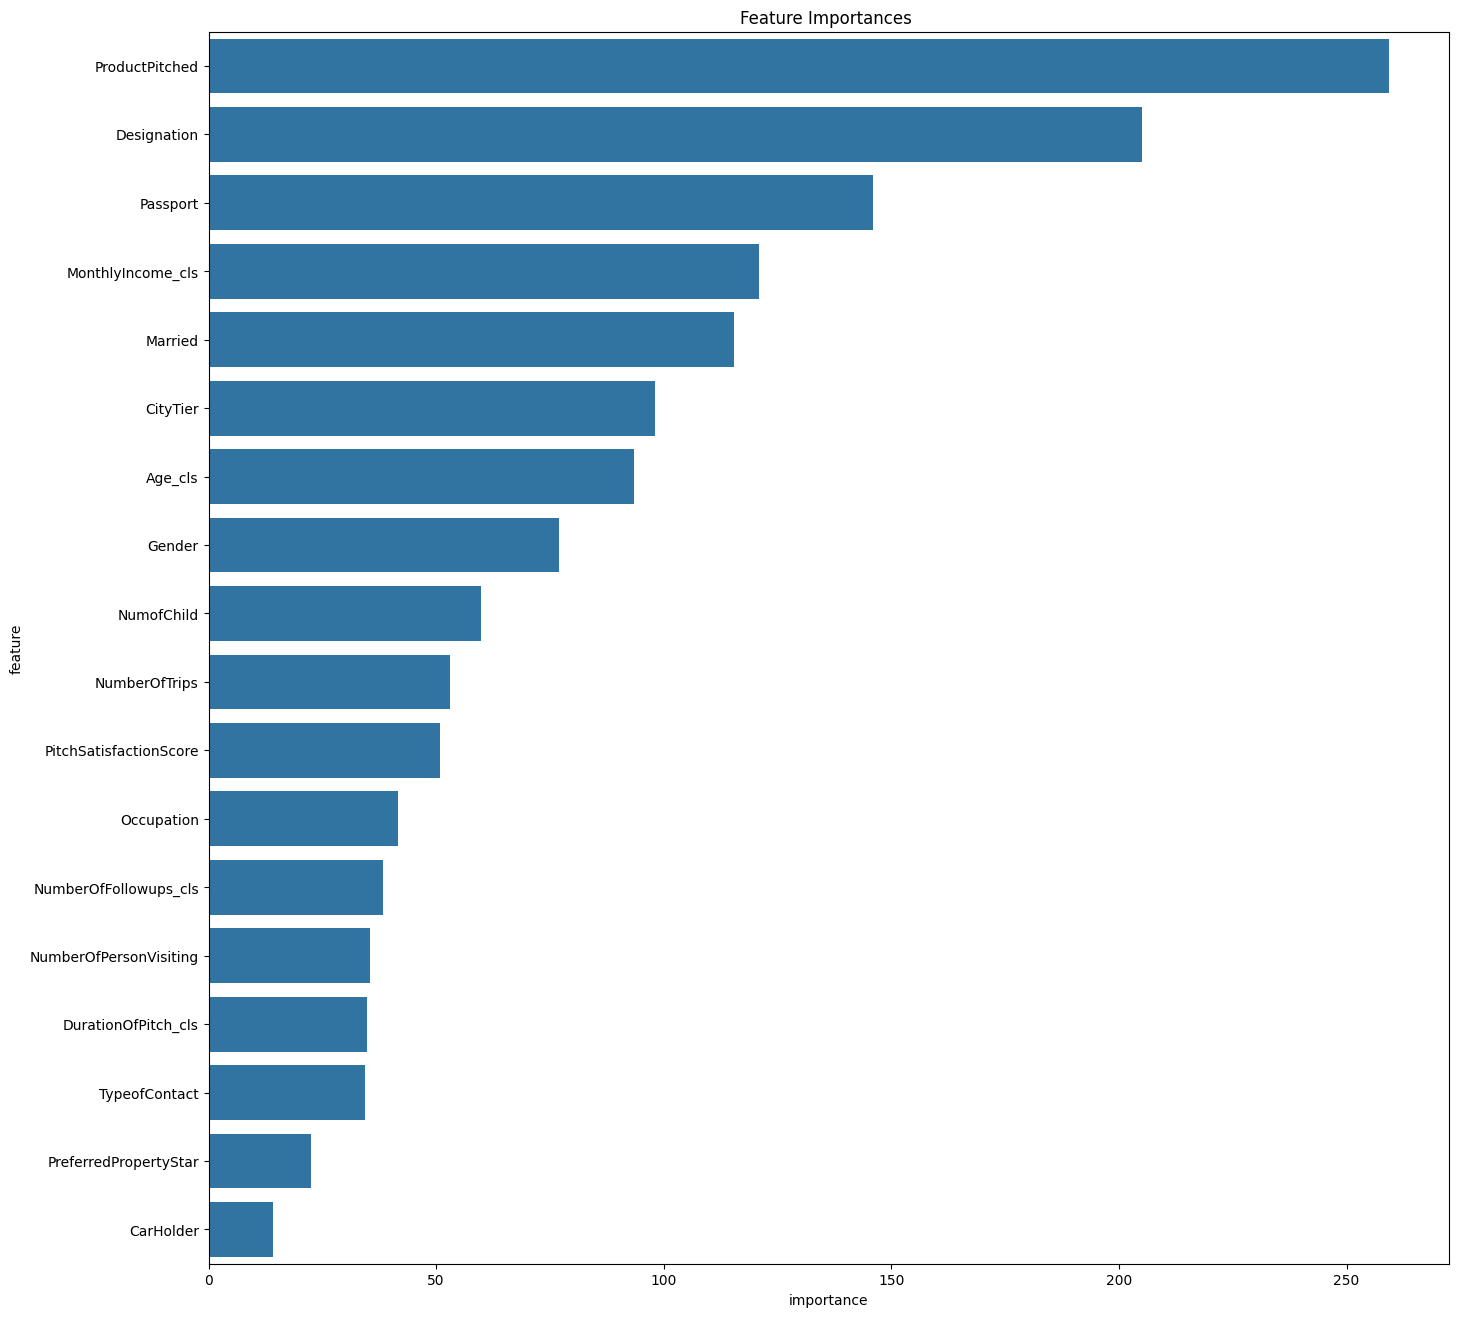

In [ ]:
plt.figure(figsize=(16, 16))
sns.barplot(data=o.sort_values(by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature Importances ')

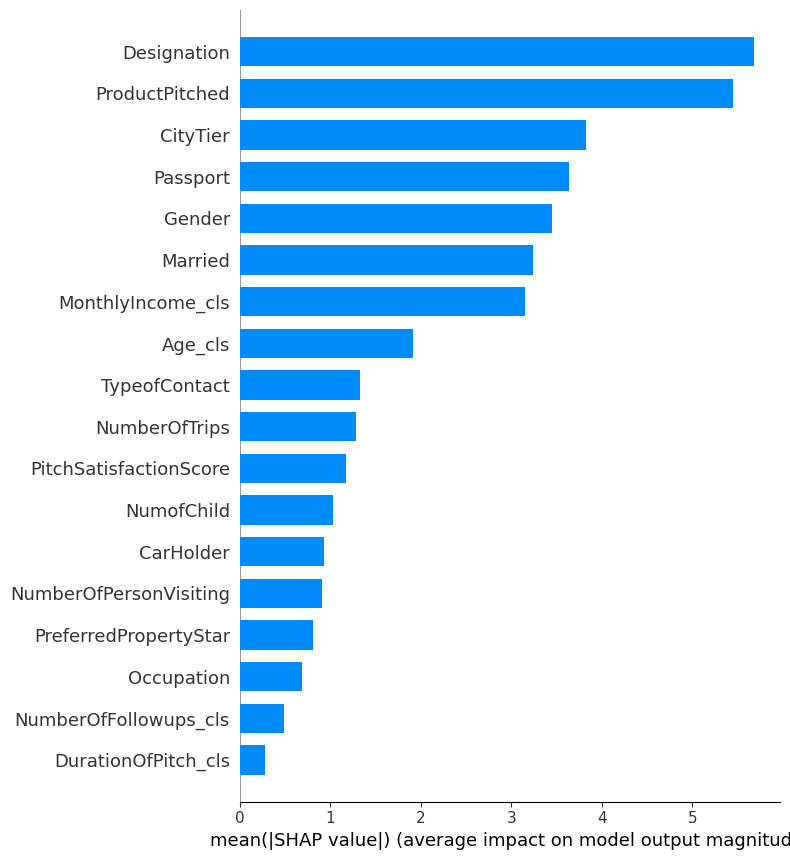

In [ ]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()

# 各FOLD、SEEDの和 (相対値なのでこれで良しとする)
shapval = 0
for i in range(3):
  for j in range(5):
    explainer = shap.TreeExplainer(models[i][j])
    shap_values = explainer.shap_values(X)
    shapval = shapval + shap_values

shap.summary_plot(shapval, X,plot_type="bar")